In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ruta de la imagen

In [56]:
path = "/content/drive/MyDrive/CNN/data/flowers/0001.png"

## Objeto `PIL.Image`

In [57]:
from PIL import Image
img = Image.open(path)


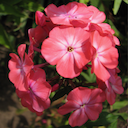

In [58]:
img

### Objeto NumPy array con forma (H, W, 3) en BGR. Donde H (Height) es la altura, W (Width) el ancho y C = 3 (Channels) los canales (rojo (R), verde (G) y azul (B)).

In [59]:
import cv2

img = cv2.imread(path)


array([[[ 10,  22,  13],
        [  9,  23,  14],
        [ 10,  24,  16],
        ...,
        [ 78, 143, 128],
        [ 85, 148, 134],
        [ 78, 140, 125]],

       [[ 10,  21,  15],
        [  9,  23,  14],
        [ 11,  25,  17],
        ...,
        [ 81, 152, 126],
        [ 96, 170, 146],
        [ 94, 158, 139]],

       [[ 10,  24,  16],
        [ 11,  25,  17],
        [ 12,  25,  17],
        ...,
        [ 32,  72,  48],
        [ 67, 139, 112],
        [ 88, 157, 135]],

       ...,

       [[ 56,  75,  92],
        [ 58,  78,  97],
        [ 58,  79,  98],
        ...,
        [ 44,  61,  76],
        [ 40,  52,  69],
        [ 37,  44,  54]],

       [[ 56,  75,  90],
        [ 57,  77,  94],
        [ 59,  79,  97],
        ...,
        [ 38,  46,  63],
        [ 22,  30,  38],
        [ 57,  61,  87]],

       [[ 55,  73,  89],
        [ 58,  77,  96],
        [ 61,  80,  99],
        ...,
        [ 38,  38,  59],
        [ 16,  25,  26],
        [ 78,  74, 117]]], dtype=uint8)
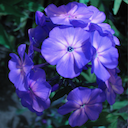

In [60]:
img

### Objeto Tensor de PyTorch. (C, H, W). El cuarto canal suele ser el canal alfa (transparencia). Formato RGBA.

In [61]:
from torchvision.io import read_image

img = read_image(path)


In [62]:
img

tensor([[[ 13,  14,  16,  ..., 128, 134, 125],
         [ 15,  14,  17,  ..., 126, 146, 139],
         [ 16,  17,  17,  ...,  48, 112, 135],
         ...,
         [ 92,  97,  98,  ...,  76,  69,  54],
         [ 90,  94,  97,  ...,  63,  38,  87],
         [ 89,  96,  99,  ...,  59,  26, 117]],

        [[ 22,  23,  24,  ..., 143, 148, 140],
         [ 21,  23,  25,  ..., 152, 170, 158],
         [ 24,  25,  25,  ...,  72, 139, 157],
         ...,
         [ 75,  78,  79,  ...,  61,  52,  44],
         [ 75,  77,  79,  ...,  46,  30,  61],
         [ 73,  77,  80,  ...,  38,  25,  74]],

        [[ 10,   9,  10,  ...,  78,  85,  78],
         [ 10,   9,  11,  ...,  81,  96,  94],
         [ 10,  11,  12,  ...,  32,  67,  88],
         ...,
         [ 56,  58,  58,  ...,  44,  40,  37],
         [ 56,  57,  59,  ...,  38,  22,  57],
         [ 55,  58,  61,  ...,  38,  16,  78]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [25

```
dataset/
│
├── train/ 70%
│   ├── perros/
│   │   ├── img001.jpg
│   │   ├── img002.jpg
│   │   └── ...
│   └── gatos/
│       ├── img003.jpg
│       ├── img004.jpg
│       └── ...
│
├── val/ 20%
│   ├── perros/
│   └── gatos/
│
└── test/ 10%
    ├── perros/
    └── gatos/

```





In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder("/content/drive/MyDrive/CNN/data/data/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [13]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [14]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_dataset   = ImageFolder("/content/drive/MyDrive/CNN/data/data/val",   transform=test_transforms)
test_dataset  = ImageFolder("/content/drive/MyDrive/CNN/data/data/test",  transform=test_transforms)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

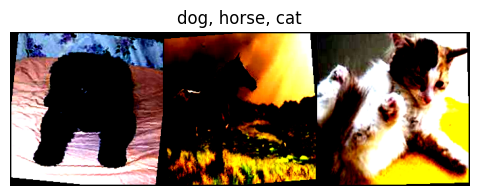

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('cat', 'dog', 'horse')
N = 3

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imgs = images[:N]
labs = labels[:N]
plt.figure(figsize=(10,2))
plt.imshow(torchvision.utils.make_grid(imgs).permute(1,2,0))
plt.title(", ".join(classes[l] for l in labs))
plt.axis("off")
plt.show()


### GPU

In [16]:
if torch.cuda.is_available():
    print("CUDA (NVIDIA GPU) is available!")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("MPS (Apple Silicon GPU) is available!")
    device = torch.device("mps")
else:
    print("No GPU available, using CPU.")
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA (NVIDIA GPU) is available!
Using device: cuda


## Modelo

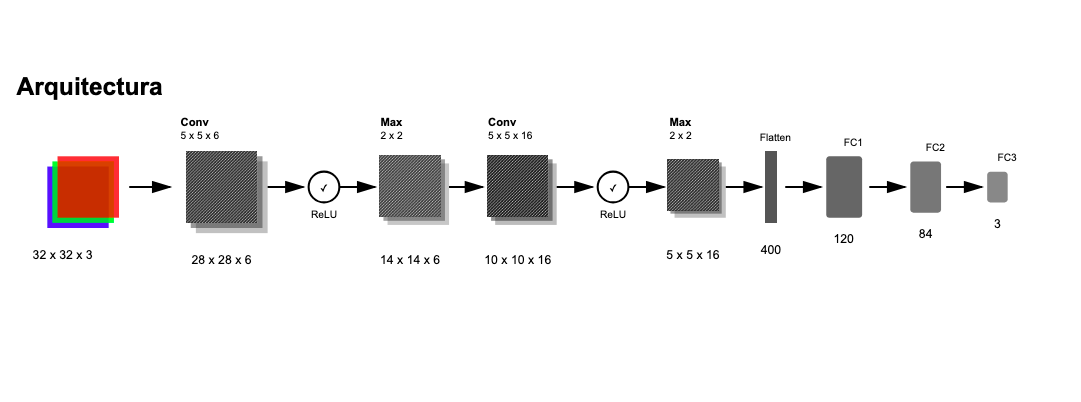

In [17]:
Arquitectura = "/content/drive/MyDrive/CNN/modelo/arquitectura.png"
arquitectura = Image.open(Arquitectura)
arquitectura

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(120)  # ← PyTorch calcula in_features solo
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)

        return x

net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

# Clasificación
* Función de pérdida: entropía cruzada.
* Método: SGD con momento.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Entrenamiento

In [20]:
EPOCHS = 25
for epoch in range(EPOCHS):
    # -------------------------------
    # TRAIN
    # -------------------------------
    net.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # -------------------------------
    # VALIDATION
    # -------------------------------
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            preds = net(x_val)
            loss = criterion(preds, y_val)

            val_loss += loss.item()

            _, predicted = torch.max(preds, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f" | Train Loss: {train_loss:.4f} "
          f" | Val Loss: {val_loss:.4f} "
          f" | Val Acc: {accuracy:.2f}%")

print("\nEntrenamiento finalizado!")

Epoch 1/25  | Train Loss: 1.0999  | Val Loss: 1.0986  | Val Acc: 34.15%
Epoch 2/25  | Train Loss: 1.0928  | Val Loss: 1.0916  | Val Acc: 34.15%
Epoch 3/25  | Train Loss: 1.0800  | Val Loss: 1.0753  | Val Acc: 47.97%
Epoch 4/25  | Train Loss: 1.0667  | Val Loss: 1.0543  | Val Acc: 43.90%
Epoch 5/25  | Train Loss: 1.0339  | Val Loss: 1.0388  | Val Acc: 39.84%
Epoch 6/25  | Train Loss: 0.9811  | Val Loss: 1.0506  | Val Acc: 47.15%
Epoch 7/25  | Train Loss: 0.9477  | Val Loss: 1.0445  | Val Acc: 41.46%
Epoch 8/25  | Train Loss: 0.9218  | Val Loss: 1.0166  | Val Acc: 47.97%
Epoch 9/25  | Train Loss: 0.8419  | Val Loss: 1.0126  | Val Acc: 50.41%
Epoch 10/25  | Train Loss: 0.8765  | Val Loss: 0.9607  | Val Acc: 51.22%
Epoch 11/25  | Train Loss: 0.7295  | Val Loss: 0.9580  | Val Acc: 46.34%
Epoch 12/25  | Train Loss: 0.6891  | Val Loss: 0.9038  | Val Acc: 56.91%
Epoch 13/25  | Train Loss: 0.7069  | Val Loss: 0.9119  | Val Acc: 54.47%
Epoch 14/25  | Train Loss: 0.6400  | Val Loss: 0.9731  | Val

In [21]:
PATH = "/content/drive/MyDrive/CNN/modelo/cnn_model.pth"
torch.save(net.state_dict(), PATH)

### Datos de prueba (test)

Comprobaremos si la red aprendió algo prediciendo la etiqueta de clase que genera la red neuronal y comparándola con la realidad. Si la predicción es correcta, añadimos la muestra a la lista de predicciones correctas.

Bien, primer paso. Veamos una imagen del conjunto de prueba para familiarizarnos.

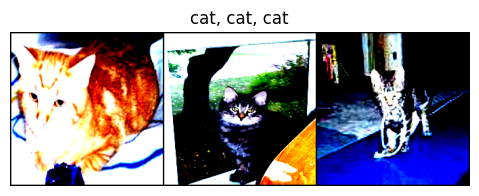

In [22]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
imgs = images[:N]
labs = labels[:N]
plt.figure(figsize=(10,2))
plt.imshow(torchvision.utils.make_grid(imgs).permute(1,2,0))
plt.title(", ".join(classes[l] for l in labs))
plt.axis("off")
plt.show()


Cargar el modelo guardado previamente

In [42]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [43]:
outputs = net(images)

In [44]:
outputs.shape

torch.Size([15, 3])

In [45]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 57 %


In [46]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 66.7 %
Accuracy for class: dog   is 57.1 %
Accuracy for class: horse is 47.6 %


In [51]:
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

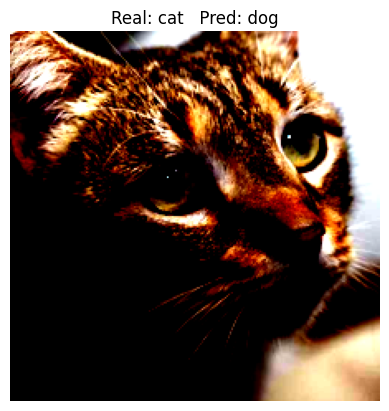

In [47]:
with torch.no_grad():
    x, y = next(iter(test_loader))
    pred = net(x)
    pred_label = pred.argmax(dim=1)

img = x[12].cpu().permute(1, 2, 0)

plt.imshow(img)
plt.title(f"Real: {classes[y[12]]}   Pred: {classes[pred_label[12]]}")
plt.axis("off")
plt.show()


### Matriz de confusión

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [30]:
def toNumpy(tensor):
    if device.type == 'cuda':
        return tensor.cpu().data.numpy()
    else:
        return tensor.data.numpy()

In [31]:
def confusion_on_X(model, dataloader):
    y_pred = []
    y_true = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model.forward(X)
        pred = toNumpy(pred.argmax(1))
        y_pred.extend(pred)  # Predicción
        y_true.extend(toNumpy(y))        # Etiquetas
        #print(pred)

    # Matriz de confusión
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.xaxis.tick_top()

    # plot matrix
    cmap = sn.color_palette("viridis", as_cmap=True)
    sn.heatmap(df_cm, annot=True, cmap=cmap)

    #plt.savefig('confusion.png')


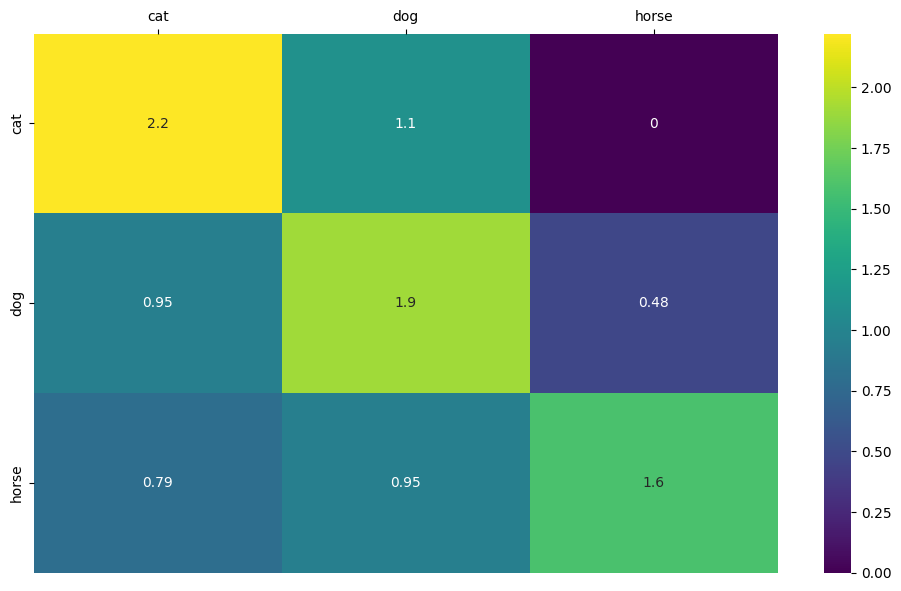

In [32]:
net.to(device)
confusion_on_X(net, test_loader)

### Veamos un ejemplo de "horse"

In [33]:
classes

('cat', 'dog', 'horse')

In [49]:
def predict_image(model, image_path, classes, device="cpu"):

    # 1. Abrir imagen
    img = Image.open(image_path).convert("RGB")

    # 2. Aplicar transforms
    img_tensor = test_transforms(img).unsqueeze(0)  # shape: [1, C, H, W]

    # 3. Pasar a GPU si es necesario
    img_tensor = img_tensor.to(device)

    # 4. Predicción
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    # 5. Regresar etiqueta como texto
    return classes[predicted.item()], img


Predicción: horse


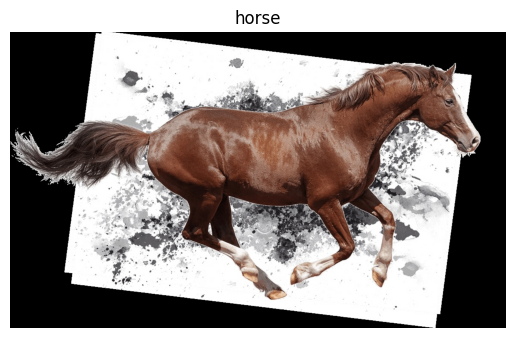

In [52]:
#horse_exam = "/content/drive/MyDrive/CNN/data/horses/horse-126.jpg"
horse_exam = "/content/drive/MyDrive/CNN/data/horses/horse-13.jpg"
label, img = predict_image(net, horse_exam, classes, device)

print("Predicción:", label)

plt.imshow(img)
plt.title(label)
plt.axis("off")
plt.show()
